# Assignment 4

### SN: 16014073

#### The whole notebook runs on my 6 core i7(mobile) CPU in about 5 minutes. The runtime is a bit higher than 2 minutes as the exercise asked to investigate the scalability of the different algorithms.

# 2D Heat/Diffusion Equation
## Introduction

For this exercise we are interested in solving the heat equation / diffusion equa-tion in 2 dimensions, on the domain $[-1,1] \times [-1,1]$. This is a linear partial differential equation, first order intime and second order in space. We have the equation  $$ \frac{\partial U}{\partial t} = \nabla^2 U $$ 
Where $$ \nabla^2 U = \frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2} $$
As usual, we need boundary conditions to be able to solve the differential equation. In this case, we have Dirichlet boundary conditions, such that at $t<0$, $U(x, y, t) = 0$, and for $t \geq 0$, $U(-1, y, t) = U(x, \pm 1, t) = 0$, and $U(1, y, t) = 5$. 

We are interested in finding the time $t^*$, where $U(0, 0, t^*) = 1$ to the highest degree of precision.


In [1]:
from __future__ import absolute_import
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs, LinearOperator, cg, bicgstab, gmres, spsolve
from scipy.linalg import solve
import pyopencl as cl
import time

FINALSOL = 0.424011387033

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

platform = cl.get_platforms()[0]    # Select the first platform [0]
device = platform.get_devices()[0]  # Select the first device on this platform [0]
ctx = cl.Context([device])
queue = cl.CommandQueue(ctx)  # Create (non-custom) command queue
mf = cl.mem_flags

## Spatial discretisation

We are going to consider solving the differential equation using a finite difference shceme, where the RHS is represented using the form we had in previous assignments.
$$
(\nabla^2 U)_{i,j} = \frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2} \approx \frac{4U_{i,j} - U_{i-1, j} - U_{i+1, j} - U_{i, j-1} - U_{i, j+1}}{h^2} 
$$

## Time steppting methods
### Forward Euler method
The forward Euler method is an explicit method, which means we can obtain the state of the domain in the next iteratiion directly from the state in the current iteration. If we consider the LHS of the equation
$$ \frac{\partial U}{\partial t} \approx \frac{U^{t+1} - U^{t}}{dt} = f(U^{t}) $$

We can insert it to the equation, and rearrange to $U^{t+1}$ :

$$
\frac{U_{i,j}^{t+1} - U_{i,j}^{t}}{dt} = \frac{4U_{i,j}^t - U_{i-1, j}^t - U_{i+1, j}^t - U_{i, j-1}^t - U_{i, j+1}^t}{h^2} 
$$

$$
h^2 \left( U_{i,j}^{t+1} - U_{i,j}^{t} \right) = dt \left( 4U_{i,j}^t - U_{i-1, j}^t - U_{i+1, j}^t - U_{i, j-1}^t - U_{i, j+1}^t \right) 
$$

$$
U_{i,j}^{t+1} = U_{i,j}^{t} + \xi \left( 4U_{i,j}^t - U_{i-1, j}^t - U_{i+1, j}^t - U_{i, j-1}^t - U_{i, j+1}^t \right)
$$

Where $\xi = \frac{dt}{h^2}$. Using the explicit Euler method, the convergence is not guaranteed, unless the parameters satisfy $dt |\lambda_{max}| < 2$, as explained in the notes.

### Forward Euler: OpenCL

I have used the OpenCL kernel we were given as a template solution for one of the previous asignments, utilizing enqueue_map_buffer to reduce memory operations. This method, however is still not very efficient. One could completely reduce the need for memory copy operations using a shared virtual memory, which could be addressed both in host and device address space. Since we are using the CPU as both a host and compute device, and the system RAM as memory, it would yield the most efficient solution. Shared Vitual Memory, however, is a feature brought forth in OpenCL 2.0, while our pocl implementation is based on OpenCL 1.2.

In [2]:
### Create a kernel which carries out the CSR multiplication
### Build kernel in the init method NOT in matvec
forward_euler_kernel = """
__kernel void discrete_laplace_explicit(__global const double* input,
                                        __global double* output,
                                        int m,
                                        double dt)
{
    int x_index = get_global_id(0);
    int y_index = get_global_id(1);

    double left;
    double right;
    double up;
    double down;
    double center;

    center = input[m * y_index + x_index];
    
    if (x_index == 0)
        left = 0.0;
    else
        left = input[m * y_index + x_index - 1];
    
    if (x_index == m-1)
        right = 0.0;
    else
        right = input[m * y_index + x_index + 1];
    
    if (y_index == 0)
        down = 5.0;
    else
        down = input[m * (y_index - 1) + x_index];
        
    if (y_index == m - 1)
        up = 0.0;
    else
        up = input[m * (y_index + 1) + x_index];
                
    output[m * y_index + x_index] = center - dt * (4 * center - left - right - up - down) * (m + 1)/2 * (m + 1)/2;
                            
}
"""


class ForwardEulerLin(LinearOperator):
    '''The discrete Laplace Operator for Explicit Method.'''
    
    def __init__(self, N, dt):
        '''Initialises operator with discretisation size N and timestep dt.'''
        
        self._N = N
        self._dt = dt
        
        self.shape = (N * N, N * N)
        self.dtype = np.dtype('float64')

        self._input_buffer = cl.Buffer(ctx, mf.READ_ONLY, np.dtype('float64').itemsize * N * N)
        self._output_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, np.dtype('float64').itemsize * N * N)

        self._kernel = cl.Program(ctx, forward_euler_kernel).build().discrete_laplace_explicit
        self._buffers = [self._input_buffer, self._output_buffer, np.int32(N), np.float64(dt)]
        
    def _matvec(self, x):
        '''Performs the matrix/vector product'''
        
        mapped_input, _ = cl.enqueue_map_buffer(queue, self._input_buffer, cl.map_flags.WRITE, 
                                             0, self._N * self._N, 'float64')
        with mapped_input.base:
            mapped_input[:] = x.astype('float64')
            
        self._kernel(queue, (self._N, self._N), None, *self._buffers)        
        
        result = np.empty(self._N * self._N, dtype='float64')
        cl.enqueue_copy(queue, result, self._output_buffer)
        queue.finish()
        
        return result.astype('float64')

    def solveSystem(self):
        '''Solves the given heat diffusion problemvon the given domain'''

        h = np.float64(2/(self._N-1))
        u = np.zeros(self._N*self._N)
        centre = (self._N*self._N)//2
        timeElapsed = 0
        iterations = 0

        while u[centre] < 1:
            u_old = np.copy(u)
            u = self._matvec(u_old)
            timeElapsed += self._dt
            iterations += 1
        
        return (timeElapsed, timeElapsed - FINALSOL, iterations)

In [3]:
### Testing for constant dt, and varying grid size
testN = [9, 17, 31, 51, 91]
dt = 1e-5
errors = []
runtimes = []

for N in testN:
    syst = ForwardEulerLin(N, dt)
    with Timer() as ttest:
        res = syst.solveSystem()
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

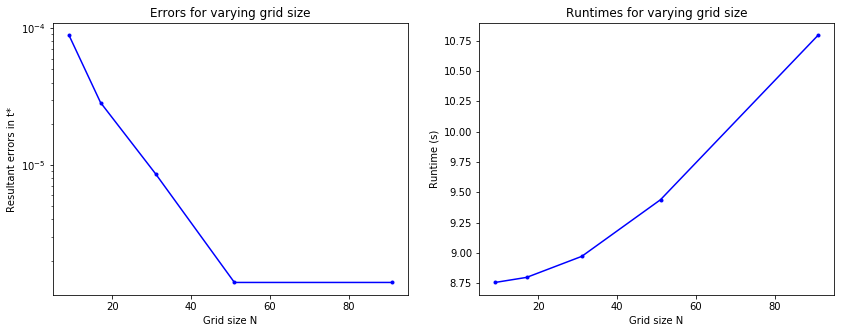

In [4]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].semilogy(testN, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying grid size');
axs[0].set_xlabel('Grid size N');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].plot(testN, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying grid size');
axs[1].set_xlabel('Grid size N');
axs[1].set_ylabel('Runtime (s)');

In [5]:
### Testing for constant N = 17, varying dt
N = 17
testdt = [1e-3, 1e-4, 5e-5, 3e-5, 1e-5]
errors = []
runtimes = []

for dt in testdt:
    syst = ForwardEulerLin(N, dt)
    with Timer() as ttest:
        res = syst.solveSystem()
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

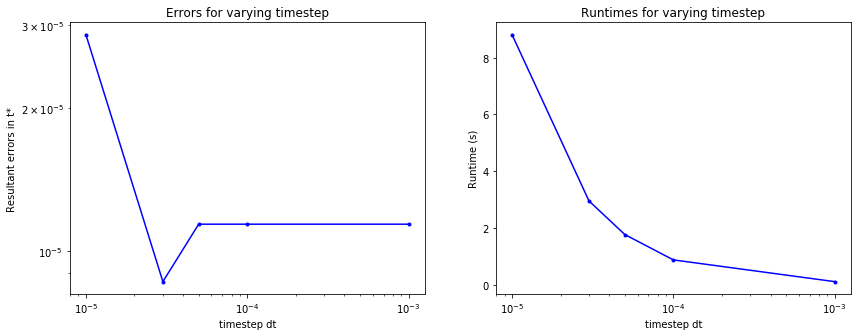

In [6]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].loglog(testdt, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying timestep');
axs[0].set_xlabel('timestep dt');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].semilogx(testdt, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying timestep');
axs[1].set_xlabel('timestep dt');
axs[1].set_ylabel('Runtime (s)');

### Forward Euler: SciPy/Numba

In this implementation a sparse matrix for the system is created explicitly, and repeated matrix multiplication is used to carry out successive iterations.

In [7]:
@njit
def forwardMatrix(N, dx, dt):
    '''
    Creates the COO matrix for the forward Euler method explicitly
    '''
    
    # Initialising the arrays for the COO matrix.
    row = []
    col = []
    data = []   
    
    for i in np.arange(N*N):
        x = i%N
        y = i//N
        
        if (x == 0) or (x == N-1) or (y == 0) or (y == N-1): 
            row.append(i)
            col.append(i)
            data.append(1)
        
        # All other are interior values
        else:
            # Centre
            row.append(i)
            col.append(i)
            data.append(-4*dt/(dx*dx) + 1)
            
            # Left
            row.append(i)
            col.append(i-1)
            data.append(dt/(dx*dx))
            
            # Right
            row.append(i)
            col.append(i+1)
            data.append(dt/(dx*dx))
            
            # Top
            row.append(i)
            col.append(i-N)
            data.append(dt/(dx*dx))
            
            # Bottom
            row.append(i)
            col.append(i+N)
            data.append(dt/(dx*dx))
            
    return (np.float64(data), (row, col))


def forwardEuler(N = 21, dt = 1e-5):
    '''
    Runs successive iterations of the forward Euler method until the temperature in the centre reaches 1
    '''
    dx = np.float64(2/(N-1))
    timeElapsed = 0
    iterations = 0
    centre = (N*N)//2

    A = sparse.coo_matrix(forwardMatrix(N, dx, dt), shape=(N*N, N*N), dtype = np.float64)
    Amat = sparse.csr_matrix(A)

    grid = np.zeros((N,N), dtype = np.float64)
    grid[:,N-1] = np.ones(N)*5
    flatGrid = grid.flatten()

    flatGrid = np.zeros(N*N)
    flatGrid[:N] = 5
    
    while (flatGrid[centre] < 1):
        timeElapsed += dt
        iterations += 1
        
        flatGrid = Amat.dot(flatGrid)

    return (timeElapsed, timeElapsed - FINALSOL, iterations)

In [8]:
### Testing for constant dt, and varying grid size
testN = [9, 17, 31, 51, 91]
dt = 1e-5
errors = []
runtimes = []

for N in testN:
    with Timer() as ttest:
        res = forwardEuler(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

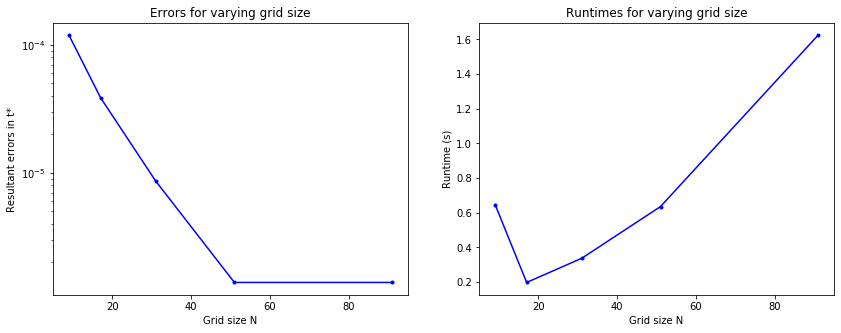

In [9]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].semilogy(testN, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying grid size');
axs[0].set_xlabel('Grid size N');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].plot(testN, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying grid size');
axs[1].set_xlabel('Grid size N');
axs[1].set_ylabel('Runtime (s)');

From these plots we can see that for a chosen timestep $dt$, even if we increase the resolution of the grid, we cannot improve the accuracy further. This is expected, as the error in the time iteration is linear in $dt$. On the other hand, lowering the resolution of the grid can reduce the accuracy below the limit imposed by the time iteration.
It is also worth noting that for larger resolutions, the time taken to solve the problem increases quadratically with the grid size. This is also expected, because a larger grid means we have to carry out a matrix multiplication in each iteration on a domain whose number of datapoints increase with $N^2$.

In [10]:
### Testing for constant N = 101, varying dt
### Grid resolution should be large enough to investigate dt.
N = 101
testdt = [5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5, 5e-6, 3e-6]
errors = []
runtimes = []

for dt in testdt:
    with Timer() as ttest:
        res = forwardEuler(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

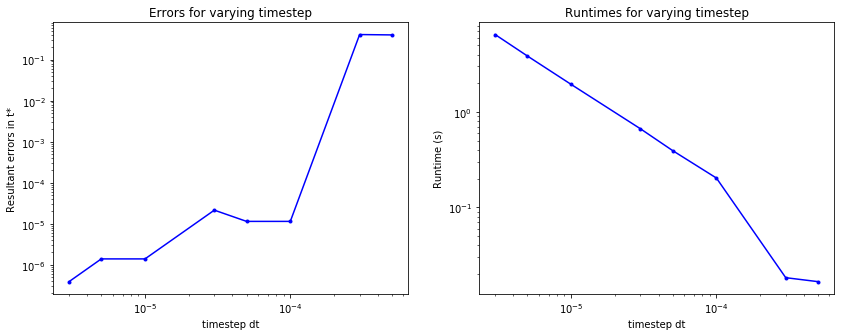

In [11]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].loglog(testdt, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying timestep');
axs[0].set_xlabel('timestep dt');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].loglog(testdt, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying timestep');
axs[1].set_xlabel('timestep dt');
axs[1].set_ylabel('Runtime (s)');

As mentioned above, given a chosen spatial resolution, we need to chose a sufficiently small timestep, or the numerical algorithm becomes unstable. We can see this as the error blows up for too large values of dt. 
On the other end of the plot, on the other hand, we can see that the result approaches the solution to a good accuracy, with a large enough spatial resolution, the error of the final result is linear in the timestep $dt$.
As we can also see from the linear slope of the loglog plot of runtimes, reducing $dt$ increases the runtime polynomially.
Hence the forward Euler method is powerful, as each iteration is a computationally rather inexpensive matrix multiplication. But it requires higly scaling runtimes to achieve a higher accuracy, as one needs to increase both the spatial and temporal resolution.

### Backward Euler method

The backward Euler method is an implicit time-stepping method, which means that it does not yield $U^{t+1}$ from $U^t$ directly, instead, it yields a system of linear equations that need to be solved to obtain $U^{t+1}$ The LHS of the equation is written as 

$$ \frac{\partial U}{\partial t} \approx \frac{U^{t+1} - U^{t}}{dt} = f(U^{t}) $$

The equation then can be rearranged to the form 

$$ 
U_{i,j}^{t} = U_{i,j}^{t+1} - \xi \left( 4U_{i,j}^{t+1} - U_{i-1, j}^{t+1} - U_{i+1, j}^{t+1} - U_{i, j-1}^{t+1} - U_{i, j+1}^{t+1} \right) 
$$

Which needs to be solved at each timestep using a linear systems solver, such as spsolve or CG. This is computationally much more expensive than the explicit method, but a great advantage is that it is unconditionally stable, regardless of the values of $h$, $dt$ and $\xi$

In [12]:
@njit
def backwardMatrix(N, dx, dt):
    '''
    Creates the COO matrix for the backward Euler method explicitly
    '''
    # Initialising the arrays for the COO matrix.
    row = []
    col = []
    data = []   
    
    for i in np.arange(N*N):
        x = i%N
        y = i//N
        
        if (x == 0) or (x == N-1) or (y == 0) or (y == N-1):
            row.append(i)
            col.append(i)
            data.append(1)
        
        # All other are interior values
        else:
            # Centre
            row.append(i)
            col.append(i)
            data.append(4*dt/(dx*dx) + 1)
            
            # Left
            row.append(i)
            col.append(i-1)
            data.append(-dt/(dx*dx))
            
            # Right
            row.append(i)
            col.append(i+1)
            data.append(-dt/(dx*dx))
            
            # Top
            row.append(i)
            col.append(i-N)
            data.append(-dt/(dx*dx))
            
            # Bottom
            row.append(i)
            col.append(i+N)
            data.append(-dt/(dx*dx))
            
    return (np.float64(data), (row, col))

def backwardEuler(N = 21, dt = 1e-5):
    '''
    Runs successive iterations of the forward Euler method until the temperature in the centre reaches 1
    '''
    dx = np.float64(2/(N-1))
    timeElapsed = 0
    iterations = 0
    centre = (N*N)//2
    
    A = sparse.coo_matrix(backwardMatrix(N, dx, dt), shape=(N*N, N*N), dtype=np.float64)
    Amat = sparse.csr_matrix(A)
    
    grid = np.zeros((N,N), dtype = np.float64)
    grid[:,N-1] = np.ones(N)*5
    flatGrid = grid.flatten()
    
    centre = (N*N)//2
    
    time = 0
    
    iterations = 0
    
    while flatGrid[centre] < 1:
        # If umfpack is installed can speed up solution of sparse system
        flatGrid = spsolve(Amat, flatGrid, use_umfpack = True)

        timeElapsed += dt
        iterations += 1

    return (timeElapsed, timeElapsed - FINALSOL, iterations)

Testing for varying grid sizes is pointless for the Backwards Euler method in the scope of this assignment. We are still limited to an error linear in $dt$, and running a small $dt$ would increase the number of iterations needed significantly, requiring solving a lot of linear systems which blows up runtime. This method works, and is unconditionally convergent, but is very resource intensive to run. 

In [13]:
### Testing for constant N = 17, varying dt
N = 17
testdt = [3e-3, 1e-3, 5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5]
errors = []
runtimes = []

for dt in testdt:
    with Timer() as ttest:
        res = backwardEuler(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

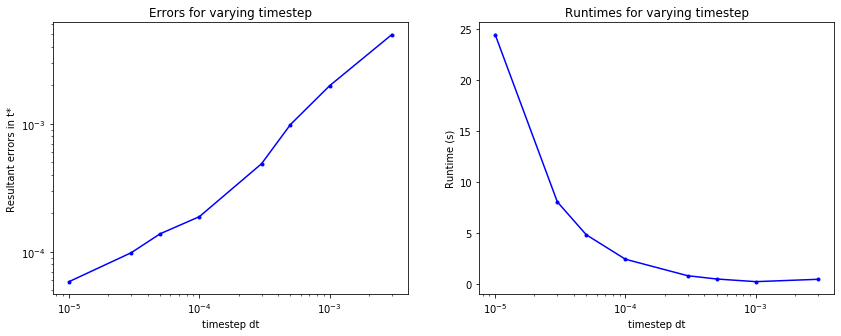

In [14]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].loglog(testdt, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying timestep');
axs[0].set_xlabel('timestep dt');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].semilogx(testdt, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying timestep');
axs[1].set_xlabel('timestep dt');
axs[1].set_ylabel('Runtime (s)');

We can see that lowering $dt$ indeed helos us reach much greater accuracy, but the runtime increases too quicly for this method to be of much use for us.

### Crank-Nicholson method

The Crank-Nicholson method is a numerically stable, implicit finite difference scheme, which is second order in time. As before, we have 

$$
\nabla^2 U_{i,j}^t = \frac{\partial^2 U^t}{\partial x^2} + \frac{\partial^2 U^t}{\partial y^2} \approx \frac{4U^t_{i,j} - U^t_{i-1, j} - U^t_{i+1, j} - U^t_{i, j-1} - U^t_{i, j+1}}{h^2} 
$$

Using

$$
\nabla^2 U_{i,j}^{t+1/2} = \frac{1}{2}[ \nabla^2 U_{i,j}^t + \nabla^2 U_{i,j}^{t+1} ]
$$

we get

$$
\frac{U_{i,j}^{t+1} - U_{i,j}^t}{dt} = \frac{1}{2}[\frac{4U^t_{i,j} - U^t_{i-1, j} - U^t_{i+1, j} - U^t_{i, j-1} - U^t_{i, j+1} + 4U^{t+1}_{i,j} - U^{t+1}_{i-1, j} - U^{t+1}_{i+1, j} - U^{t+1}_{i, j-1} - U^{t+1}_{i, j+1}}{h^2} ]
$$

And can rearrange to

$$
2 U_{i,j}^{t+1} + \xi [4U^{t+1}_{i,j} - U^{t+1}_{i-1, j} - U^{t+1}_{i+1, j} - U^{t+1}_{i, j-1} - U^{t+1}_{i, j+1}] = 2U_{i,j}^t + \xi [4U^t_{i,j} - U^t_{i-1, j} - U^t_{i+1, j} - U^t_{i, j-1} - U^t_{i, j+1}]
$$

Which is a matrix equation of the form 

$$ M U^{t+1} = N U^t $$
$$ M U^{t+1} = b $$
with $b = N U^t$

It is still an implicit method, so a linear system needs to be solved at each iteration, but it has a better time-convergence and accuracy than tha backward Euler method. It is not very useful in our case though, as solving linear systems for large grids is very resource intensive, so we lose accuracy in the spatial discretisation.

In [15]:
def crankNicholsonM(N, dx, dt):
    '''
    Create M matrix for the CN method
    '''
    
    # Backward matrix with factor of 2 on the diagonal element
    # Initialising the arrays for the COO matrix.
    row = []
    col = []
    data = []   
    
    for i in np.arange(N*N):
        x = i%N
        y = i//N
        
        if (x == 0) or (x == N-1) or (y == 0) or (y == N-1): 
            row.append(i)
            col.append(i)
            data.append(1)
        
        # All other are interior values
        else:
            # Centre
            row.append(i)
            col.append(i)
            data.append(4*dt/(dx*dx) + 2)
            
            # Left
            row.append(i)
            col.append(i-1)
            data.append(-dt/(dx*dx))
            
            # Right
            row.append(i)
            col.append(i+1)
            data.append(-dt/(dx*dx))
            
            # Top
            row.append(i)
            col.append(i-N)
            data.append(-dt/(dx*dx))
            
            # Bottom
            row.append(i)
            col.append(i+N)
            data.append(-dt/(dx*dx))
            
    return (np.float32(data), (row, col))

def crankNicholsonN(N, dx, dt):
    '''
    Create N matrix for the CN method
    '''
    # Forward matrix with factor of 2 on the diagonal element
    # Initialising the arrays for the COO matrix.
    row = []
    col = []
    data = []   
    
    for i in np.arange(N*N):
        x = i%N
        y = i//N
        #print(dt/(dx*dx))
        
        # Boundary values, in order:
        # Left Most
        # Right Most
        # Top Most
        # Bottom and Right
        if x == 0 \
        or x == N-1 \
        or y == 0 \
        or y == N-1: 
            row.append(i)
            col.append(i)
            data.append(1)
        
        # All other are interior values
        else:
            # Centre
            row.append(i)
            col.append(i)
            data.append(-4*dt/(dx*dx) + 2)
            
            # Left
            row.append(i)
            col.append(i-1)
            data.append(dt/(dx*dx))
            
            # Right
            row.append(i)
            col.append(i+1)
            data.append(dt/(dx*dx))
            
            # Top
            row.append(i)
            col.append(i-N)
            data.append(dt/(dx*dx))
            
            # Bottom
            row.append(i)
            col.append(i+N)
            data.append(dt/(dx*dx))
            
    return (np.float32(data), (row, col))

def crankNicholson(N = 21, dt = 1e-5):
    '''
    Runs successive iterations of the forward Euler method until the temperature in the centre reaches 1
    '''

    dx = np.float32(2/(N-1))
    timeElapsed = 0
    iterations = 0
    centre = (N*N)//2
    
    A = sparse.coo_matrix(crankNicholsonM(N, dx, dt), shape=(N*N, N*N), dtype = np.float64).tocsr()

    grid = np.zeros((N,N), dtype = np.float64)
    grid[:,N-1] = np.ones(N)*5
    flatGrid = grid.flatten()

    Nmat = sparse.coo_matrix(crankNicholsonN(N, dx, dt), shape=(N*N, N*N))
    

    while flatGrid[centre] < 1:

        b = Nmat @ flatGrid
        flatGrid = spsolve(A, b, use_umfpack = True)

        timeElapsed += dt
        iterations += 1

    return (timeElapsed, timeElapsed - FINALSOL, iterations)


In [16]:
### Testing for constant N = 17, varying dt
N = 17
testdt = [3e-3, 1e-3, 5e-4, 3e-4, 1e-4, 5e-5]
errors = []
runtimes = []

for dt in testdt:
    with Timer() as ttest:
        res = crankNicholson(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

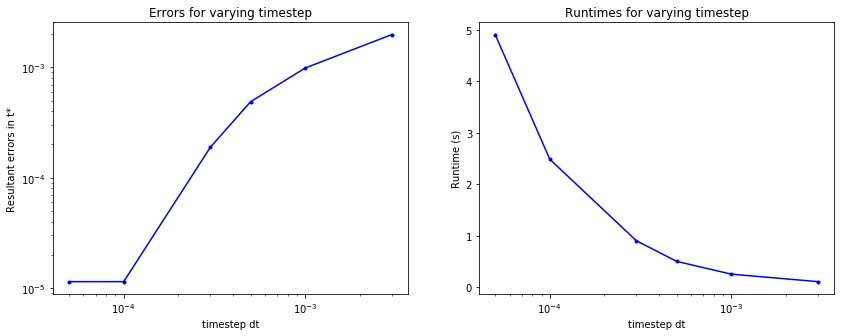

In [17]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].loglog(testdt, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying timestep');
axs[0].set_xlabel('timestep dt');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].semilogx(testdt, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying timestep');
axs[1].set_xlabel('timestep dt');
axs[1].set_ylabel('Runtime (s)');

The Crank-Nicholson improves upon the Backwards Euler as it converges in much fewer iterations, hence requires less time to run. On the other hand, as this is still an implicit method, a linear system needs to be solved in each iteration, and it scales very poorly with grid size. One of the main problems is that as heat dissipates through our domain, the RHS of our matrix equation changes from sparse to dense, making it troublesome to pick an appropriate solver method.

### Spectral Differentiation

The given domain can be numerically approximated in a different method, called *Spectral Differentiation*. It involves creating a differentiation matrix $D$ that approximates the Laplacian. For it to be accurate throughout the domain, the sampling distribution must be skewed towards the sides. This is done by using the Chebychev function that spreads the points according to $x_i = \cos \left( \frac{\pi \cdot i}{M-1} \right)$, where $i = 0, 1, 2, ... , M-1$. The differentiation matrix $D$ is created using the following rules:

$$
D_{0,0} = \frac{2M^2+1}{6} \label{eq:11} \tag{11}
$$

$$
D_{M,M} = -\frac{2M^2+1}{6} \label{eq:12} \tag{12}
$$

$$
D_{i,i} = -\frac{-x_i}{2 \left( 1-x_i \right)^2} \label{eq:13} \tag{13}
$$

for $i= 1, 2, ... , M-1$

$$
D_{i,j} = \frac{c_i}{c_j} \frac{\left( -1 \right)^{i+j}}{\left( x_i - x_j \right)} \label{eq:14} \tag{14}
$$

for $i \neq j$. $c_{i,j} = 2$ for $i = 0, M$ and $c_{i,j} = 1$ otherwise. To create a differentiation matrix associated with the second order derivative, $D$ is squared. The *explicit* time step iteration is calculated by:

$$
u^{t+1} = \left( I + dt \cdot A \right) u^t \label{eq:15} \tag{15}
$$

where $A = I \otimes D^2 + D^2 \otimes I$.

In [18]:
def cheb(M):
    '''
    Creates Differntial Matrix D and Chebyshev function space discretisation.
    '''
    M = M-1
    if M==0:
        D = np.array([[0.]]); x = np.array([1.])
    else:
        n = np.arange(0,M + 1)
        x = np.cos(np.pi* n / M).reshape(M + 1, 1) 
        c = (np.hstack(( [2.], np.ones(M - 1), [2.]))*(-1)**n).reshape(M + 1,1)
        X = np.tile(x,(1,M + 1))
        dX = X - X.T
        D = np.dot(c,1./c.T)/(dX + np.eye(M + 1))
        D -= np.diag( np.sum( D.T, axis=0))
    return D, x.reshape(M + 1)

def spectral_explicit_solve(M, dt):
    '''
    Solves the given heat spread problem using spectral differentiation
    '''
    
    h = np.float64(2/(M-1))
    
    D, x = cheb(M)
    D2 = D @ D
    I = np.eye(M)
    A = (np.kron(D2, I) + np.kron(I, D2))
    I2 = np.eye(M**2)
    
    A = sparse.csr_matrix(A)
    I2 = sparse.csr_matrix(I2)

    u = np.zeros(M**2)
    u[:M] = 5
    
    midpoint = (M*M)//2
    timeElapsed = 0
    iterations = 0
    
    while u[midpoint] < 1:
        
        u_old = np.copy(u)        
        u = (I2 + dt*A).dot(u_old)
        
        u[:M] = 5
        u[M:M*(M-1):M] = 0
        u[M+M-1:M*(M-1):M] = 0
        u[M*(M-1):] = 0

        timeElapsed += dt
        iterations += 1

    return (timeElapsed, timeElapsed - FINALSOL, iterations)

In [19]:
### Testing for constant dt, and varying grid size
testN = [5, 7, 9, 11, 13]
dt = 5e-6
errors = []
runtimes = []

for N in testN:
    with Timer() as ttest:
        res = spectral_explicit_solve(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

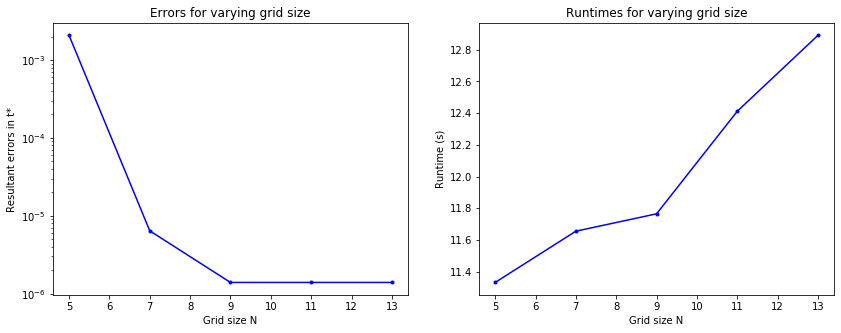

In [20]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].semilogy(testN, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying grid size');
axs[0].set_xlabel('Grid size N');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].plot(testN, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying grid size');
axs[1].set_xlabel('Grid size N');
axs[1].set_ylabel('Runtime (s)');

The above plots show that the solution does not improve with increasing the grid size. This means we can use the grid size N = 9 for the solutions, and vary the timestep. I have checked that the grid size does not matter for smaller timesteps either, so this is not just the case of hitting the limitations of the timestep selected.

In [21]:
### Testing for constant N = 9, varying dt
N = 9
testdt = [5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5, 5e-6, 3e-6, 1e-6]
errors = []
runtimes = []

for dt in testdt:
    with Timer() as ttest:
        res = spectral_explicit_solve(N, dt)
    
    errors.append(res[1])
    runtimes.append(ttest.interval)

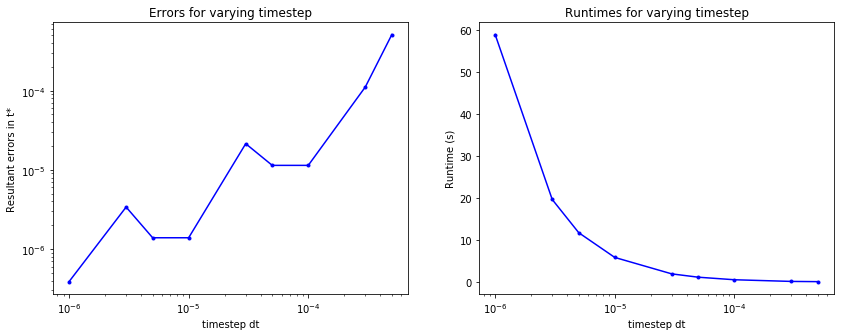

In [22]:
fig, axs = plt.subplots(1, 2, sharex='row', figsize=(14,5))

errorsPlot = axs[0].loglog(testdt, np.abs(errors), 'b.-');
axs[0].set_title('Errors for varying timestep');
axs[0].set_xlabel('timestep dt');
axs[0].set_ylabel('Resultant errors in t*');

runtimesPlot = axs[1].semilogx(testdt, runtimes, 'b.-');
axs[1].set_title('Runtimes for varying timestep');
axs[1].set_xlabel('timestep dt');
axs[1].set_ylabel('Runtime (s)');

The spectral method is the most successful of the tested algorithms, gets close to the result quickly, and scales reasonably well with lowering the timestep. As shown below, with a 10 minute runtime it was able to reach 7 s.f. accuracy.

In [23]:
'''
This testing illustrates the scalability of the spectral method with smaller timesteps, if we have more time to run the calculations.

N_test = 11
dt_test = 1e-7

with Timer() as t:
    asd = spectral_explicit_solve(N_test, dt_test)

print("Time taken to run: {0}".format(t.interval))
print("Error delt* = {0}".format(asd[1]))

Time taken to run: 618.8413910865784
Error delt* = -8.702183723618973e-08
''';